In [1]:
from gstools import SRF, Gaussian
import pandas as pd
import pykrige as krig
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import minmax_scale, StandardScaler
import matplotlib
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.model_selection import train_test_split
%matplotlib inline


grid_size = 20 #Cube size
x_range = y_range = z_range =range(1, grid_size+1)
seed = 2313 #necessary to keep a relation between grades, litho, and alter.

c:\Users\yair0\.conda\envs\Yairama\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Gaussian 3D block simulation

### Generate Random 3D block for grades

c:\Users\yair0\.conda\envs\Yairama\lib\site-packages\gstools\field\plot.py:277: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: title={'center': 'Field 3D structured (20, 20, 20)'}, xlabel='$x$', ylabel='$y$'>

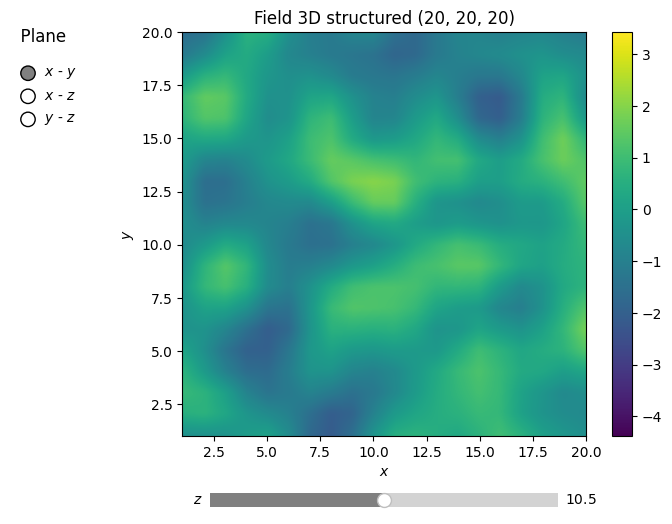

In [2]:
model_grades = Gaussian(dim=3, var=1, len_scale=2)
srf_grades = SRF(model_grades, seed=seed)
field_grades = srf_grades.structured([x_range, y_range, z_range])
field_grades = field_grades + np.ndarray.min(field_grades)*-1

srf_grades.plot()

### Getting 3D coordinates from grade block

In [3]:
df_simulation_grade = pd.DataFrame(columns=['x','y','z','finos'])
for i in range(len(x_range)):
    for j in range(len(y_range)):
        for k in range(len(z_range)):
            df_temp = pd.DataFrame({
                'x': [x_range[i]],
                'y': [y_range[j]],
                'z': [z_range[k]],
                'finos': [field_grades[i][j][k]]
            })
            df_simulation_grade = pd.concat([df_simulation_grade,df_temp])
df_simulation_grade.reset_index(inplace=True, drop=True)
df_simulation_grade

,x,y,z,finos
0,1,1,1,4.692909
1,1,1,2,5.276404
2,1,1,3,6.127534
3,1,1,4,7.067388
4,1,1,5,6.976891
...,...,...,...,...
7995,20,20,16,7.038114
7996,20,20,17,5.564531
7997,20,20,18,4.250091
7998,20,20,19,3.784030


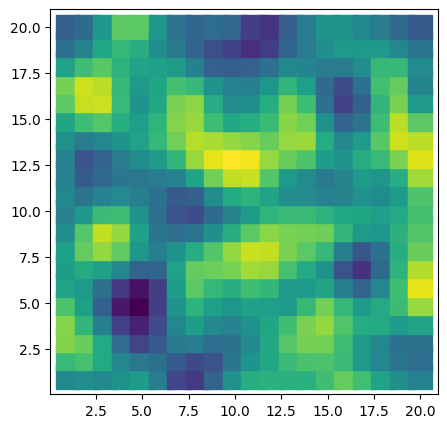

In [4]:
"""Real Plot plan XY with z=10"""
fig = plt.gcf()
fig.set_size_inches(5,5)

# plt.imshow(np.flip(np.transpose(field_grades), 1)[0])

z_to_plot=10
plt.scatter(df_simulation_grade[df_simulation_grade['z']==z_to_plot]['x'],
 df_simulation_grade[df_simulation_grade['z']==z_to_plot]['y'],
 c=df_simulation_grade[df_simulation_grade['z']==z_to_plot]['finos'],
 marker='s',
 s=300)

### Generate Random 3D block for litho

c:\Users\yair0\.conda\envs\Yairama\lib\site-packages\gstools\field\plot.py:277: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: title={'center': 'Field 3D structured (20, 20, 20)'}, xlabel='$x$', ylabel='$y$'>

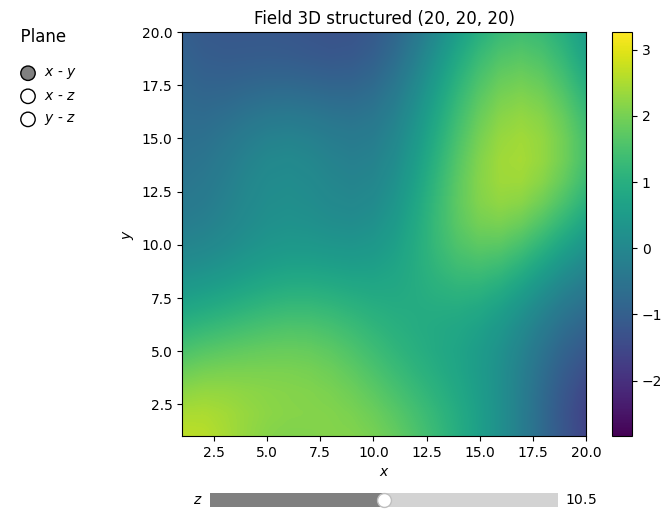

In [5]:
model_litho = Gaussian(dim=3, var=1, len_scale=6)
srf_litho = SRF(model_litho, seed=seed)
field_litho = srf_litho.structured([x_range, y_range, z_range])
field_litho = field_litho - np.ndarray.min(field_litho)
srf_litho.plot()

In [6]:
df_simulation_litho = pd.DataFrame(columns=['x','y','z','finos'])
for i in range(len(x_range)):
    for j in range(len(y_range)):
        for k in range(len(z_range)):
            df_temp = pd.DataFrame({
                'x': [x_range[i]],
                'y': [y_range[j]],
                'z': [z_range[k]],
                'finos': [field_litho[i][j][k]]
            })
            df_simulation_litho = pd.concat([df_simulation_litho,df_temp])
df_simulation_litho.reset_index(inplace=True, drop=True)

df_simulation_litho['litho']=''
df_simulation_litho.loc[df_simulation_litho['finos']<2.5, 'litho'] = 'Litho_A'
df_simulation_litho.loc[(df_simulation_litho['finos']>=2.5) & (df_simulation_litho['finos']<4),'litho'] = 'Litho_B'
df_simulation_litho.loc[(df_simulation_litho['finos']>=4), 'litho'] = 'Litho_C'
df_simulation_litho.drop(['finos'], axis=1, inplace=True)
df_simulation_litho



,x,y,z,litho
0,1,1,1,Litho_B
1,1,1,2,Litho_B
2,1,1,3,Litho_B
3,1,1,4,Litho_B
4,1,1,5,Litho_C
...,...,...,...,...
7995,20,20,16,Litho_C
7996,20,20,17,Litho_C
7997,20,20,18,Litho_C
7998,20,20,19,Litho_C


<AxesSubplot: xlabel='x', ylabel='y'>

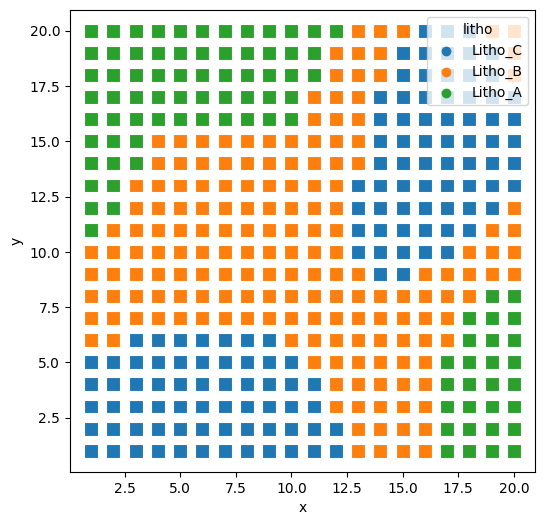

In [7]:
"""Real Plot plan XY with z=10"""
fig = plt.gcf()
fig.set_size_inches(6,6)

# plt.imshow(np.flip(np.transpose(field_grades), 1)[0])

z_to_plot=10
sns.scatterplot(x=df_simulation_litho[df_simulation_litho['z']==z_to_plot]['x'],
 y=df_simulation_litho[df_simulation_litho['z']==z_to_plot]['y'],
 hue=df_simulation_litho[df_simulation_litho['z']==z_to_plot]['litho'],
 marker='s',
 s=100)

### Generate Random 3D block for Alter

c:\Users\yair0\.conda\envs\Yairama\lib\site-packages\gstools\field\plot.py:277: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: title={'center': 'Field 3D structured (20, 20, 20)'}, xlabel='$x$', ylabel='$y$'>

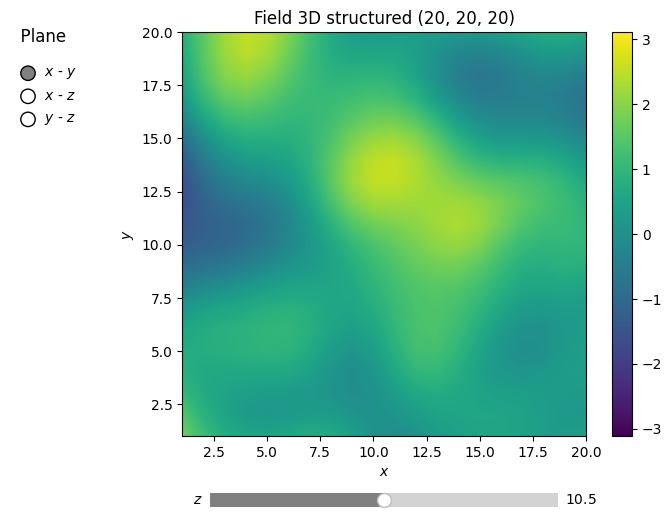

In [8]:
model_alter = Gaussian(dim=3, var=1, len_scale=3.3)
srf_alter = SRF(model_alter, seed=seed)
field_alter = srf_alter.structured([x_range, y_range, z_range])
field_alter = field_alter - np.ndarray.min(field_alter)
srf_alter.plot()

In [9]:
df_simulation_alter = pd.DataFrame(columns=['x','y','z','finos'])
for i in range(len(x_range)):
    for j in range(len(y_range)):
        for k in range(len(z_range)):
            df_temp = pd.DataFrame({
                'x': [x_range[i]],
                'y': [y_range[j]],
                'z': [z_range[k]],
                'finos': [field_alter[i][j][k]]
            })
            df_simulation_alter = pd.concat([df_simulation_alter,df_temp])
df_simulation_alter.reset_index(inplace=True, drop=True)

df_simulation_alter['alter']=''

df_simulation_alter.loc[(df_simulation_alter['finos']<3),'alter'] = 'Alter_A'
df_simulation_alter.loc[(df_simulation_alter['finos']>=3) & (df_simulation_alter['finos']<4),'alter'] = 'Alter_B'
df_simulation_alter.loc[(df_simulation_alter['finos']>=4) & (df_simulation_alter['finos']<5),'alter'] = 'Alter_C'
df_simulation_alter.loc[(df_simulation_alter['finos']>=5),'alter'] = 'Alter_D'
df_simulation_alter.drop(['finos'], axis=1, inplace=True)
df_simulation_alter

,x,y,z,alter
0,1,1,1,Alter_B
1,1,1,2,Alter_B
2,1,1,3,Alter_C
3,1,1,4,Alter_C
4,1,1,5,Alter_D
...,...,...,...,...
7995,20,20,16,Alter_B
7996,20,20,17,Alter_B
7997,20,20,18,Alter_B
7998,20,20,19,Alter_B


<AxesSubplot: xlabel='x', ylabel='y'>

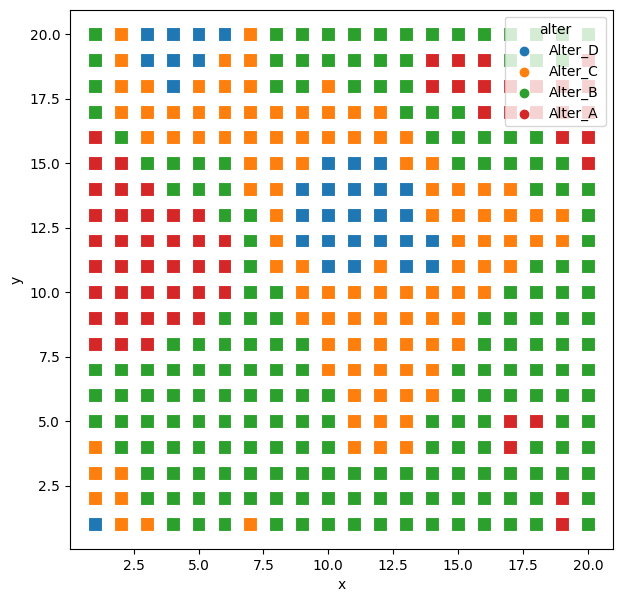

In [10]:
"""Real Plot plan XY with z=10"""
fig = plt.gcf()
fig.set_size_inches(7,7)

# plt.imshow(np.flip(np.transpose(field_grades), 1)[0])

z_to_plot=10
sns.scatterplot(x=df_simulation_alter[df_simulation_alter['z']==z_to_plot]['x'],
 y=df_simulation_alter[df_simulation_alter['z']==z_to_plot]['y'],
 hue=df_simulation_alter[df_simulation_alter['z']==z_to_plot]['alter'],
 marker='s',
 s=100)

### Merging Datasets & save

In [11]:
df_simulation = df_simulation_grade.merge(df_simulation_litho, on=['x','y','z'])
df_simulation = df_simulation.merge(df_simulation_alter, on=['x','y','z'])
df_simulation.to_csv('data/simulation_data.csv',index=False)

### Getting sample from 3D block as vertical drill hole

Text(0.5, 1.0, 'Drill holes - plan view')

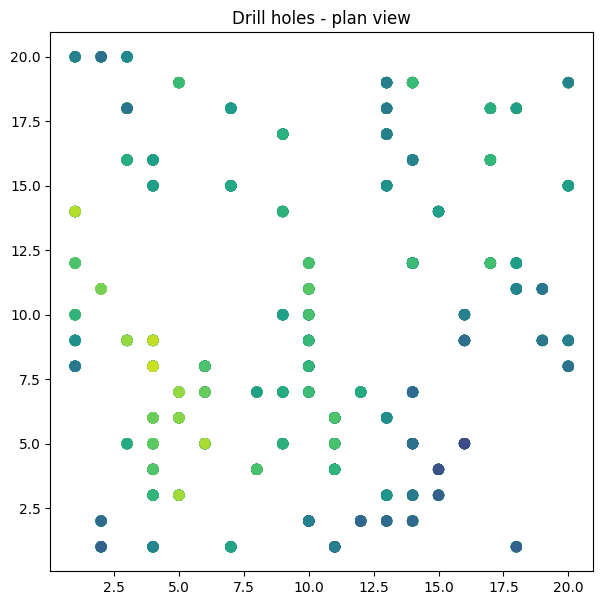

In [12]:
numer_of_drillholes = 100

df_simulation[['x','y','z']] = df_simulation[['x','y','z']].astype(float)

x_y_grid = np.array(np.meshgrid(np.arange(1,grid_size+1,1), np.arange(1,grid_size+1,1))).T.reshape(-1,2)
df_simulation_sample = pd.DataFrame(columns=['x','y','z','finos'])
for item in np.random.default_rng().choice(x_y_grid,numer_of_drillholes):
    df_temp = df_simulation[(df_simulation['x']==item[0]) & (df_simulation['y']==item[1])]
    df_simulation_sample = pd.concat([df_temp, df_simulation_sample])

fig = plt.gcf()
fig.set_size_inches(7,7)
plt.scatter(df_simulation_sample['x'],df_simulation_sample['y'],
c=df_simulation_sample['finos'], marker='o', s=50)
plt.title('Drill holes - plan view')

### (Optional) Gaussian 3D kriggin to compare
#### Be careful about computing time

Use a grid_size of 20, higher values may crash the python kernel (depends on machine).

The code:
```
UK = krig.OrdinaryKriging3D(
    x=df_simulation_sample['x'],
    y=df_simulation_sample['y'],
    z=df_simulation_sample['z'],
    val=df_simulation_sample['finos'],
    variogram_model="gaussian"
)
```

May take several minutes to run. In a grid_size of 20 takes around 2 minutes. Computing time can increase exponentially

In [13]:
"""

UK = krig.OrdinaryKriging3D(
    x=df_simulation_sample['x'],
    y=df_simulation_sample['y'],
    z=df_simulation_sample['z'],
    val=df_simulation_sample['finos'],
    variogram_model="gaussian"
)
gridx = np.arange(1., float(grid_size)+1.0, 1.)
gridy = np.arange(1., float(grid_size)+1.0, 1.)
gridz = np.arange(1., float(grid_size)+1.0, 1.)
z, ss = UK.execute(
    style="grid",
    xpoints= gridx,
    ypoints= gridy,
    zpoints= gridz
)

df_result = pd.DataFrame(columns=['x','y','z','finos'])
for i in range(len(gridz)):
    for j in range(len(gridy)):
        for k in range(len(gridx)):
            df_temp = pd.DataFrame({
                'x': [gridx[k]],
                'y': [gridy[j]],
                'z': [gridz[i]],
                'finos': [z.data[i][j][k]]
            })
            df_result = pd.concat([df_result,df_temp])
df_result.reset_index(inplace=True, drop=True)

df_result = df_result.merge(df_simulation_grade, on=['x','y','z'], suffixes=['_pred','_real'])

print("r2: ", r2_score(df_result['finos_real'], df_result['finos_pred']))
print("mae: ", mean_absolute_error(df_result['finos_real'], df_result['finos_pred']))
print("mape: ", mean_absolute_percentage_error(df_result['finos_real'], df_result['finos_pred']))

#Kriggin Plot plan XY with z=10
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,6)
ax[0].scatter(df_result[df_result['z']==z_to_plot]['x'],
 df_result[df_result['z']==z_to_plot]['y'],
 c=df_result[df_result['z']==z_to_plot]['finos_pred'],
 marker='s',
 s=100)
ax[1].scatter(df_result[df_result['z']==z_to_plot]['x'],
 df_result[df_result['z']==z_to_plot]['y'],
 c=df_result[df_result['z']==z_to_plot]['finos_real'],
 marker='s',
 s=100)
# plt.colorbar()
ax[0].set_title('Predicted')
ax[1].set_title('Real')

"""

'\n\nUK = krig.OrdinaryKriging3D(\n    x=df_simulation_sample[\'x\'],\n    y=df_simulation_sample[\'y\'],\n    z=df_simulation_sample[\'z\'],\n    val=df_simulation_sample[\'finos\'],\n    variogram_model="gaussian"\n)\ngridx = np.arange(1., float(grid_size)+1.0, 1.)\ngridy = np.arange(1., float(grid_size)+1.0, 1.)\ngridz = np.arange(1., float(grid_size)+1.0, 1.)\nz, ss = UK.execute(\n    style="grid",\n    xpoints= gridx,\n    ypoints= gridy,\n    zpoints= gridz\n)\n\ndf_result = pd.DataFrame(columns=[\'x\',\'y\',\'z\',\'finos\'])\nfor i in range(len(gridz)):\n    for j in range(len(gridy)):\n        for k in range(len(gridx)):\n            df_temp = pd.DataFrame({\n                \'x\': [gridx[k]],\n                \'y\': [gridy[j]],\n                \'z\': [gridz[i]],\n                \'finos\': [z.data[i][j][k]]\n            })\n            df_result = pd.concat([df_result,df_temp])\ndf_result.reset_index(inplace=True, drop=True)\n\ndf_result = df_result.merge(df_simulation_grade,